In [1]:
import numpy as np
import pymc as pm # if using pymc >=4
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

import pandas as pd

import json

from pytensor.tensor import cumsum
import pytensor.tensor as at

from glob import glob

In [2]:
conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

ridx, cidx = np.triu_indices(len(conditions), k = 1)

times = np.linspace(-400, 1400, 901)
trim_idx = (times >= -250) & (times <= 1000)  # for trimming EEG down
times = times[trim_idx]

# details for compressing down the time bins, for faster computation
bin_starts = times[::5][:-1]
t_idx_starts = np.where([t in bin_starts for t in times])[0]

# defining delay period, excluding window when numbers never could have appeared
bin_ends = bin_starts+10
delay_period = (bin_starts >= 150) & (bin_ends <=1000)  # full delay is 150-1000ms

In [3]:
# drop_subs = ['003', '010', '014', '019', '021', '022']
drop_subs = []

In [4]:
# df["median_split"] = (df.response<df.response.quantile()).replace({True:1, False:2})
f = open('k_estimates.json')
k_res = json.load(f)
k_df = pd.DataFrame(pd.DataFrame(k_res).loc[['4','6','8']].mean())  # average across SS4-8
k_df['high_k'] = k_df[0] > k_df[0].quantile()
k_df

k_df = k_df[~k_df.index.isin(drop_subs)]  # drop subjects without chain convergence NOTE: this is hacky, and doesn't rebalance mean split

In [5]:
rdm_files = sorted(glob('sub_rdms/sub_*.npy'))
rdm_files = [f for f in rdm_files if f.split('_')[-1].split('.')[0] not in drop_subs]
rdm_files

['sub_rdms/sub_001.npy',
 'sub_rdms/sub_002.npy',
 'sub_rdms/sub_003.npy',
 'sub_rdms/sub_004.npy',
 'sub_rdms/sub_005.npy',
 'sub_rdms/sub_007.npy',
 'sub_rdms/sub_008.npy',
 'sub_rdms/sub_009.npy',
 'sub_rdms/sub_010.npy',
 'sub_rdms/sub_011.npy',
 'sub_rdms/sub_012.npy',
 'sub_rdms/sub_013.npy',
 'sub_rdms/sub_014.npy',
 'sub_rdms/sub_015.npy',
 'sub_rdms/sub_016.npy',
 'sub_rdms/sub_019.npy',
 'sub_rdms/sub_021.npy',
 'sub_rdms/sub_022.npy',
 'sub_rdms/sub_023.npy',
 'sub_rdms/sub_024.npy',
 'sub_rdms/sub_025.npy',
 'sub_rdms/sub_026.npy']

In [6]:
# Number of Items in WM
WM_setsizes = np.array([int(cond[1]) if (cond[0] == 'M') else 0 for cond in conditions])
WMss_options = sorted(np.unique(WM_setsizes))
WM_setsize_map = {ss:i for i,ss in enumerate(WMss_options)}
cond_WMss_idx = np.array([WM_setsize_map[ss] for ss in WM_setsizes])

# Number of attended areas, assuming that people can filter our distractors
condition_ATTN = np.array([int(cond[1]) for cond in conditions])
ATTNss_options = sorted(np.unique(condition_ATTN))
ATTN_setsize_map = {ss:i for i,ss in enumerate(ATTNss_options)}
cond_ATTNss_idx = np.array([ATTN_setsize_map[ss] for ss in condition_ATTN])

# stimulus energy, carved up for a monotonic function
condition_stimEnergy = np.array([int(cond[1]) if cond[2]=='N' else 10 for cond in conditions])
stimEnergy_options = sorted(np.unique(condition_stimEnergy))
stimEnergy_map = {ss:i for i,ss in enumerate(stimEnergy_options)}
cond_stimEnergy_idx = np.array([stimEnergy_map[ss] for ss in condition_stimEnergy])

q = np.array([
    cond_WMss_idx[ridx], cond_WMss_idx[cidx],
    cond_ATTNss_idx[ridx], cond_ATTNss_idx[cidx],
    cond_stimEnergy_idx[ridx], cond_stimEnergy_idx[cidx],
]).T

In [7]:
def build_model(d, q):
    '''
    Build a model to estimate the WM and spatial attention functions with the following assumptions:
    1. The WM function is a guassian random walk, **is the same with or without placeholders**
    2. The spatial attention function is monotonic, **and is the same with or without placeholders**
    3. The stimulus energy function is monotonic

    **s indicate assumptions specific to this model

    Arguments
    ---------
    d : array of shape (n_distances,)
        The vectorized distances in upper (or lower) triangle of RDM
    q : array of shape (n_distances, n_regressors)
        Condition indices
    For this model the following column structure is expected:
    0. WM set size at first condition
    1. WM set size at second condition
    2. Spatial attention set size at first condition
    3. Spatial attention set size at second condition
    4. Stimulus energy at first condition
    5. Stimulus energy at second condition
    
    '''
    N = len(d)
    wmK = np.unique(q[:, :2]).size # number of WM set sizes
    attnK = np.unique(q[:, 2:4]).size # number of attended areas
    StimEnergyK = np.unique(q[:, 4:6]).size # number of stimulus energy levels
    nsub = np.unique(q[:, 7]).size  # number of subjects
    
    # check that the quad indices are in the expected format
    assert np.min(q) == 0 
    assert q.shape[0] == N 
    assert (np.max(q[:, :2]) + 1) == wmK
    assert (np.max(q[:, 2:4]) + 1) == attnK
    assert (np.max(q[:, 4:6]) + 1) == StimEnergyK
    
    # steps between conditions we'd like to fit to data    
    coords = {
        'innovations_num_WM': np.arange(1, wmK),
        'innovations_num_Attn': np.arange(1, attnK), 
        'innovations_num_StimEnergy': np.arange(1, StimEnergyK),
        'subject': np.arange(0, nsub),
        'trial_num': np.arange(1, N + 1),
    }
    
    with pm.Model(coords = coords) as model:

        # prior on noise in RDM values
        sigma = pm.Exponential('sigma', .1)

        # betas for funcs & intercept
        # for functions, we need a positively biased prior, because things are symmetric when you convert to distances
        beta_Attn = pm.Exponential('beta_Attn', lam=5)
        beta_StimEnergy = pm.Exponential('beta_StimEnergy', lam=5)
        beta_intercept = pm.Normal('beta_intercept', mu = 0, sigma = .25)

        # could add individual intercepts too...
        # beta_intercept_sub = pm.Normal('beta_int_sub', mu = 0, sigma = 1, dims = ('subject',))
        # intercept_sigma = pm.Exponential('intercept_sigma', lam=5)            
        # WM prior on changes between successive levels in underlying function
        # assumes gaussian process, with random step between levels

        # population-level walk
        sigma_innov_WM = pm.Exponential('sigma_innov_WM', lam=5)  # mean of 1/5 = 0.2 SDs
        sigma_init_WM = pm.Exponential('sigma_init_WM', lam=.2)  # mean of 1/0.2 = 5

        mu_WM = pm.GaussianRandomWalk(
            'mu_minus_first_WM',
            mu = 0,
            sigma = sigma_innov_WM,
            init_dist = pm.Exponential.dist(lam=sigma_init_WM),
            dims = ('innovations_num_WM',)
        )
        mu_WM = pm.Deterministic('mu_WM', pm.math.concatenate(([0.], mu_WM)))


        # sub-specific walks, to combine with the population-level walks below
        # note - unlike population-level walks, the first steps are centered around 0
        sigma_pop = pm.Exponential('sigma_innov_WM_pop', lam=8)
        sigma_sub = pm.Exponential('sigma_innov_WM_sub', lam=5, shape=nsub)
        mu_wm_sub = pm.MvGaussianRandomWalk('mu_minus_first_WM_sub',
                                                mu=np.zeros(nsub),
                                                chol=at.diag(sigma_sub),
                                                dims=('innovations_num_WM', 'subject'),
                                              )
        mu_WM_sub = pm.Deterministic('mu_WM_sub', pm.math.concatenate((np.zeros((1,nsub)), mu_wm_sub), axis=0))  # add 0s to start of every subject's walk


        # Spatial Attention prior on changes between successive levels in underlying function
        # assumes monotonic function via dirichlet distribution
        # TODO: also make a random walk version of this, with individual subject walks
        dir_Attn = pm.Dirichlet('dir_Attn', a = np.ones(attnK-1), dims = ('innovations_num_Attn',))
        mu_Attn = pm.Deterministic('mu_Attn_minus_first', cumsum(beta_Attn*dir_Attn))
        mu_Attn = pm.Deterministic('mu_Attn', pm.math.concatenate(([0.], mu_Attn)))


        # Stimulus Energy prior on changes between successive levels in underlying function
        # assumes monotonic function via dirichlet distribution
        # TODO: consider making a random walk version of this...
        dir_StimEnergy = pm.Dirichlet('dir_StimEnergy', a = np.ones(StimEnergyK-1), dims = ('innovations_num_StimEnergy',))
        mu_StimEnergy = pm.Deterministic('mu_StimEnergy_minus_first', cumsum(beta_StimEnergy*dir_StimEnergy))
        mu_StimEnergy = pm.Deterministic('mu_StimEnergy', pm.math.concatenate(([0.], mu_StimEnergy)))
 
        
        # likelihood function
        # start by getting difference scores between pairs of conds based on WM and attn set sizes
        mu_i_WM = mu_WM[q[:, 0].astype(int)] + sigma_pop*mu_WM_sub[q[:, 0].astype(int), q[:, 7].astype(int)]
        mu_j_WM = mu_WM[q[:, 1].astype(int)] + sigma_pop*mu_WM_sub[q[:, 1].astype(int), q[:, 7].astype(int)]
        mu_delta_WM = pm.math.abs(mu_i_WM - mu_j_WM)



        mu_i_Attn = mu_Attn[q[:, 2].astype(int)]
        mu_j_Attn = mu_Attn[q[:, 3].astype(int)]
        mu_delta_Attn = pm.math.abs(mu_i_Attn - mu_j_Attn)



        mu_i_StimEnergy = mu_StimEnergy[q[:, 4].astype(int)]
        mu_j_StimEnergy = mu_StimEnergy[q[:, 5].astype(int)]
        mu_delta_StimEnergy = pm.math.abs(mu_i_StimEnergy - mu_j_StimEnergy)



        # old model where we had different funcs for high-k and low-k separately, and that was it... worked ok, but high-k func was noisy
        # dist_est =  mu_delta_WM_hk + (1-q[:, 6].astype(int))*mu_delta_WM_lk +\
        #             mu_delta_Attn_hk + (1-q[:, 6].astype(int))*mu_delta_Attn_lk +\
        #             mu_delta_StimEnergy_hk + (1-q[:, 6].astype(int))*mu_delta_StimEnergy_lk +\
        #             beta_intercept + intercept_sigma*beta_intercept_sub[q[:, 7].astype(int)]  # subject-specific intercepts

        dist_est =  mu_delta_WM +\
                    mu_delta_Attn +\
                    mu_delta_StimEnergy +\
                    beta_intercept
        
        pm.Normal(
            'd', 
            mu = dist_est,
            sigma = sigma,
            observed = d, 
            dims = ("trial_num",)
        )
        
    return model

In [8]:
# build up distances and inputs

for i,f in enumerate(rdm_files):
    sub_id = f.split('_')[-1].split('.')[0]
    sub_rdms = np.load(f)
    sub_rdm_delay = sub_rdms[...,delay_period].mean(-1)

    sub_dists = sub_rdm_delay[ridx, cidx]

    sub_q = np.concatenate([q,
                            np.array([[k_df.loc[sub_id, 'high_k']] * q.shape[0]]).T,    # add column to differentiate k groups
                            np.array([[i] * q.shape[0]]).T                              # add column to index subjects
                            ], axis = 1)  

    if i == 0:
        pop_dists = sub_dists
        pop_q = sub_q
    else:
        pop_dists = np.concatenate((pop_dists, sub_dists))
        pop_q = np.concatenate((pop_q, sub_q), axis = 0)

print(pop_dists.shape, pop_q.shape)

(2640,) (2640, 8)


In [9]:
# fit model

model = build_model(pop_dists, pop_q)

with model:
    trace = pm.sample(
        5000, # real samples per chain
        tune = 2000, # warmup samples per chain
        chains = 4,
        target_accept = 0.9,
        random_seed = 42, 
        return_inferencedata = True
    )

/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/pymc/distributions/timeseries.py:353: UserWarning: Initial distribution not specified, defaulting to `MvNormal.dist(0, I*100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_Attn, beta_StimEnergy, beta_intercept, sigma_innov_WM, sigma_init_WM, mu_minus_first_WM, sigma_innov_WM_pop, sigma_innov_WM_sub, mu_minus_first_WM_sub, dir_Attn, dir_StimEnergy]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 3319 seconds.
There were 4349 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [21]:
# check the effective sample size
summary_table = az.summary(trace, var_names = ['mu_WM', 'mu_Attn', 'mu_StimEnergy', 'sigma', 'beta_intercept', 'mu_WM_sub'])
summary_table

/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_WM[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
mu_WM[1],0.210,0.167,0.000,0.473,0.030,0.021,31.0,125.0,1.10
mu_WM[2],0.122,0.166,-0.125,0.371,0.027,0.019,39.0,95.0,1.09
mu_WM[3],0.109,0.167,-0.143,0.361,0.029,0.020,36.0,87.0,1.10
mu_WM[4],0.116,0.167,-0.134,0.370,0.027,0.019,40.0,94.0,1.09
...,...,...,...,...,...,...,...,...,...
"mu_WM_sub[4, 17]",0.479,1.899,-2.395,3.819,0.620,0.453,11.0,75.0,1.32
"mu_WM_sub[4, 18]",-0.043,1.693,-2.830,3.055,0.424,0.305,18.0,126.0,1.18
"mu_WM_sub[4, 19]",0.044,1.690,-2.914,2.954,0.434,0.313,17.0,119.0,1.19
"mu_WM_sub[4, 20]",0.250,1.592,-2.755,2.922,0.302,0.216,26.0,136.0,1.19


In [20]:
simple_table = []
for row in summary_table.iterrows():
    if 'mu_WM_sub' not in row[0]:
        simple_table.append(row[1])
pd.DataFrame(simple_table)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_WM[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
mu_WM[1],0.210,0.167,0.000,0.473,0.030,0.021,31.0,125.0,1.10
mu_WM[2],0.122,0.166,-0.125,0.371,0.027,0.019,39.0,95.0,1.09
mu_WM[3],0.109,0.167,-0.143,0.361,0.029,0.020,36.0,87.0,1.10
mu_WM[4],0.116,0.167,-0.134,0.370,0.027,0.019,40.0,94.0,1.09
mu_Attn[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
mu_Attn[1],0.094,0.011,0.074,0.114,0.002,0.001,29.0,108.0,1.09
mu_Attn[2],0.120,0.013,0.095,0.145,0.004,0.003,11.0,35.0,1.25
mu_Attn[3],0.142,0.017,0.108,0.172,0.006,0.005,9.0,30.0,1.37
mu_StimEnergy[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN


/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  wa

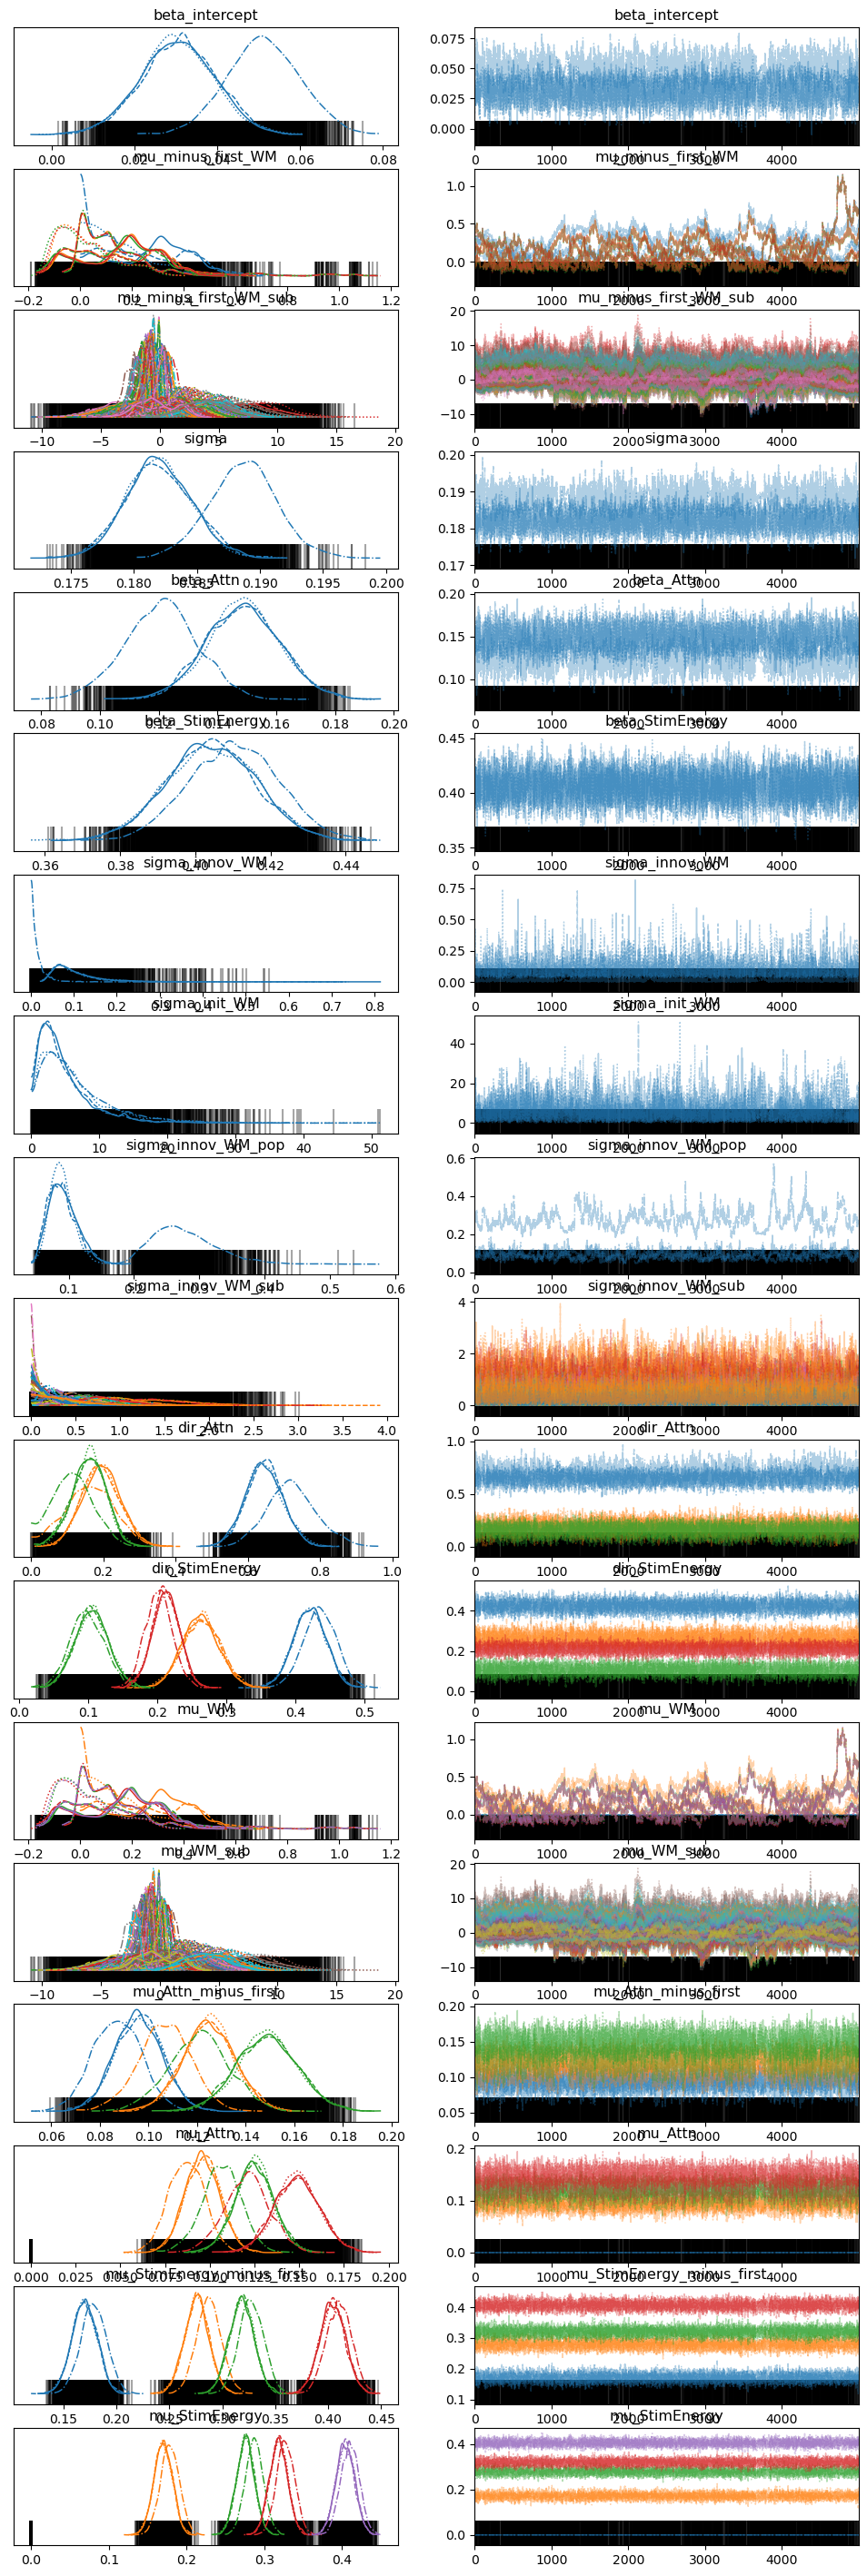

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_89514/528579141.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lower = az.hdi(mu_WM.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_89514/528579141.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  upper = az.hdi(mu_WM.T)[:, 1]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_89514/528579141.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lower = az.hdi(mu_Attn.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_89514/528579141.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future re

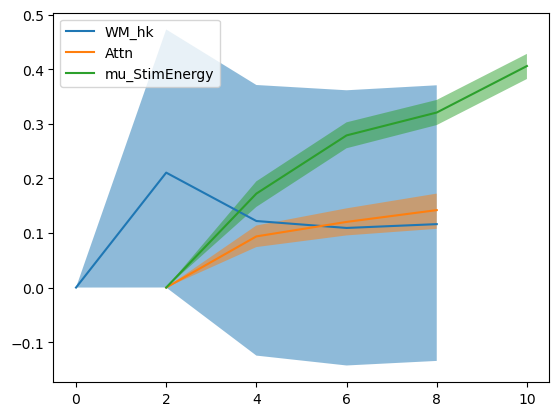

In [22]:
_ = pm.plot_trace(trace)
plt.show()
plt.close()

# plot posterior of functios w/ HDI
trc = trace.posterior.stack(draws = ("chain", "draw"))

# Load function
mu_WM = trc['mu_WM'].values
lower = az.hdi(mu_WM.T)[:, 0]
upper = az.hdi(mu_WM.T)[:, 1]
ax = sns.lineplot(x=[0, 2, 4, 6, 8], y=mu_WM.mean(1), label='WM_hk')
plt.fill_between([0, 2, 4, 6, 8], lower, upper, alpha = .5)

# Spatial attention
mu_Attn = trc['mu_Attn'].values
lower = az.hdi(mu_Attn.T)[:, 0]
upper = az.hdi(mu_Attn.T)[:, 1]
ax = sns.lineplot(x=[2, 4, 6, 8], y=mu_Attn.mean(1), label='Attn')
plt.fill_between([2, 4, 6, 8], lower, upper, alpha = .5)

# Stimulus Energy
mu_StimEnergy = trc['mu_StimEnergy'].values
lower = az.hdi(mu_StimEnergy.T)[:, 0]
upper = az.hdi(mu_StimEnergy.T)[:, 1]
ax = sns.lineplot(x=[2, 4, 6, 8, 10], y=mu_StimEnergy.mean(1), label='mu_StimEnergy')
plt.fill_between([2, 4, 6, 8, 10], lower, upper, alpha = .5)


plt.xticks([0, 2, 4, 6, 8, 10])
plt.legend()
plt.show()